<a href="https://colab.research.google.com/github/likeaAI/ai_study/blob/main/imagesegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  33.7M      0  0:00:22  0:00:22 --:--:-- 36.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  12.4M      0  0:00:01  0:00:01 --:--:-- 12.4M


In [101]:
import os 
input_dir = 'images'
target_dir = 'annotations/trimaps'

img_size = (160,160)
num_classes = 3 
batch_size = 32 

input_img_paths = sorted([os.path.join(input_dir, fname)  
                      for fname in os.listdir(input_dir)
                      if fname.endswith('.jpg')])


target_img_paths = sorted([os.path.join(target_dir, fname)  
                      for fname in os.listdir(target_dir)
                      if fname.endswith('.png') and not fname.startswith('.')])





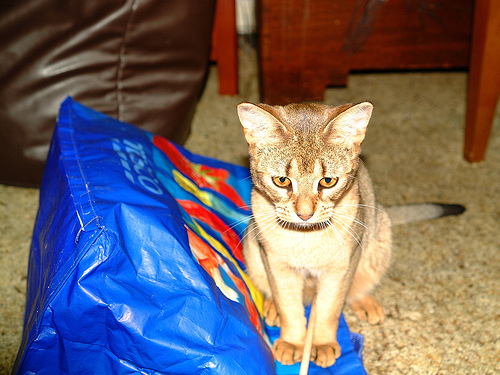

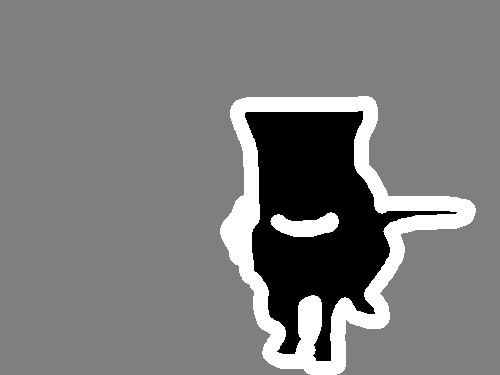

In [102]:
from IPython.display import Image, display 
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)

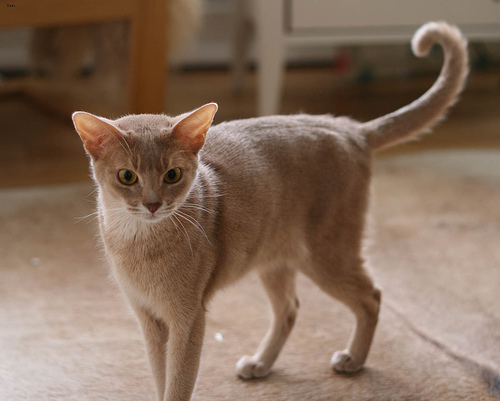

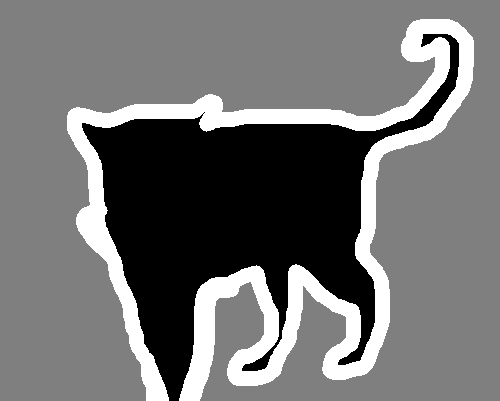

In [103]:
display(Image(filename=input_img_paths[20]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[20]))
display(img)

In [104]:
# 데이터 전처리   

In [105]:
import numpy as np 
from tensorflow import keras

class OxfordPets(keras.utils.Sequence) : 
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths) : 
    self.batch_size = batch_size
    self.img_size =img_size
    self.target_img_paths = target_img_paths

  def __len__(self) : 
    return len(self.target_img_paths) // self.batch_size
  
  def __getitem__(self, idx) : 
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size) + self.img_size + (3,), dtype = 'flot32')
    for j, path in enumerate(batch_input_img_paths) : 
      img  = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size) + self.img_size + (1,), dtype = 'uint8')
    for j, path in enumerate(batch_target_img_paths) : 
      img = load_img(path, target_size=self.img_size , color_mode='grayscale')
      y[j] = np.expand_dims(img, 2 )
      y[j] -=  1

    return x, y  

In [112]:
import random


val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples : ]
val_target_img_paths = target_img_paths[-val_samples : ]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)





In [107]:
# 모델구성 

In [108]:
from tensorflow.keras import layers 

def get_model(img_size, num_classes): 
  inputs = keras.Input(shape = img_size + (3,))

  x = layers.Conv2D(32, 3, strides = 2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x 


  for filters in [64, 128 , 256 ]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters , 3,  padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters , 3,  padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2 , padding='same')(previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x 


  for filters in [256, 128, 64 , 32] : 
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters , 3,  padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters , 3,  padding = 'same')(x)
    x = layers.BatchNormalization()(x)


    x= layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1 , padding='same')(residual)
    x = layers.add([x, residual])
    previous_block_activation = x 

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding = 'same')(x)

  model = keras.Model(inputs, outputs)

  return model

In [109]:
model = get_model(img_size, num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 80, 80, 32)   896         ['input_15[0][0]']               
                                                                                                  
 batch_normalization_63 (BatchN  (None, 80, 80, 32)  128         ['conv2d_35[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [113]:
model.compile(optimizer='RMSprop' , loss='sparse_categorical_crossentropy')
callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.h5' , save_best_only=True)]
epochs = 20


model.fit(train_gen, epochs=epochs , validation_data = val_gen, callbacks=callbacks)



AttributeError: ignored

In [115]:
val_preds = model.predict(val_gen)

def display_mask(i) :
  mask = np.argmax(val_preds[i] , axis=-1)
  mask = np.expand_dims(mask, axis= -1 )
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

i = 20

display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths))
display(img)
display_mask(i)




AttributeError: ignored

In [ ]:
# deeplab 기반 세그멘테이션 